# Exploratory Data Analysis in Python

In this course I'm going to share with you my techniques and thought processes for exploratory data analysis.  I'll demonstrate everything with analysis of a real data set.  It is important to emphasize that there isn't a single right way to do exploratory data analysis.  The way you explore your data depends on the questions you're trying to answer and the data itself.  As such, you shouldn't try to replicate this analysis exactly, rather let the data and your curiousity guide you.  

There are a few core libraries you want to become familiar with.  This includes:

* NumPy: provides the core array class for efficient storage and vectorized computation.
* Pandas: wraps NumPy arrays with a series and dataframe object providing lots of convenient methods.
* SciPy: a wide variety of scientific computation tools, including statistics, optimization and signal processing.
* Scikit-learn: a wide variety of machine learning methods, as well as data processing helpers.
* Matplotlib: The most full-featured Python plotting library.  Generates static images.
* Bokeh: A new plotting library.  Able to render interactive plots in notebooks.



In [252]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings

from scipy.stats import gaussian_kde, anderson, skew, kurtosis
from itertools import zip_longest, count, cycle
from helpers import block_heatmap, scatter_with_hover
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import FastICA
from statsmodels.distributions.empirical_distribution import ECDF
from ipywidgets import interact
from matplotlib.colors import ListedColormap

bar_color = "cornflowerblue"

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 5)

## The dataset



In [2]:
df = pd.read_excel("Data_Cortex_Nuclear.xls", index_col=0)

df = df.fillna(df.mean())
df_numeric = df.filter(like="_N", axis=1)

## Generating additional summary statistics

Pandas dataframes has a handy method called describe.  Describe gives you a variety of summary statistics for each variable.  The summary statistics returned by this method are also a dataframe, so you can amend it easily to include other statistics.  We'll do exactly that, adding the variable's coefficient of variation.

The coefficient of variation is just the ratio of the standard deviation to the mean of the distribution.  Distributions with a large coefficient of variation are more likely to signal a change in the underlying data generation process, as opposed to random variation.

In [3]:
description = df.describe()
coef_variation = description.loc["std"] / description.loc["mean"]
description.loc["cova"] = coef_variation
description.sort_values(by="cova", axis=1)

,ERBB4_N,P3525_N,BAX_N,GFAP_N,pGSK3B_Tyr216_N,PSD95_N,ARC_N,pS6_N,pGSK3B_N,CDK5_N,...,Tau_N,pPKCG_N,pCAMKII_N,pP70S6_N,ITSN1_N,SOD1_N,BRAF_N,DYRK1A_N,pERK_N,AcetylH3K9_N
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.156478,0.291276,0.179307,0.120889,0.848767,2.235236,0.121521,0.121521,0.161211,0.292434,...,0.210489,1.706599,3.537109,0.394475,0.617102,0.542635,0.378519,0.425810,0.545904,0.216482
std,0.015071,0.030015,0.018826,0.013233,0.094311,0.254395,0.014276,0.014276,0.019308,0.037380,...,0.069010,0.578442,1.293368,0.155953,0.251290,0.280178,0.216087,0.249015,0.344829,0.185309
min,0.100217,0.207438,0.072326,0.086114,0.577397,1.206098,0.067254,0.067254,0.099976,0.181157,...,0.096233,0.598767,1.343998,0.131120,0.245359,0.217120,0.143894,0.145327,0.149155,0.052528
25%,0.146969,0.270059,0.168172,0.112765,0.793739,2.079338,0.110839,0.110839,0.149253,0.272594,...,0.167991,1.296830,2.479861,0.282131,0.473669,0.319712,0.264356,0.288163,0.337486,0.103571
50%,0.156371,0.290646,0.180745,0.120459,0.849858,2.242197,0.121626,0.121626,0.160212,0.293820,...,0.188630,1.664560,3.329624,0.378673,0.566365,0.446027,0.326730,0.366540,0.444223,0.150417
75%,0.165421,0.311602,0.191577,0.127724,0.916173,2.420226,0.131955,0.131955,0.171739,0.312484,...,0.233943,2.112973,4.480652,0.480704,0.697500,0.695318,0.412716,0.487574,0.663173,0.269653
max,0.208698,0.443735,0.241141,0.213621,1.204598,2.877873,0.158748,0.158748,0.253210,0.817402,...,0.602768,3.381976,7.464070,1.129171,2.602662,1.872899,2.133416,2.516367,3.566685,1.459387
cova,0.096313,0.103047,0.104995,0.109467,0.111116,0.113811,0.117482,0.117482,0.119768,0.127823,...,0.327855,0.338945,0.365657,0.395343,0.407210,0.516329,0.570875,0.584803,0.631665,0.856000


## Normalization

One important initial step before any real analysis is performed is to normalize the data.  This is necessary in order to prevent variables with large values from having an undue influence on results. There are a few different methods of normalizing your data:
 
* The most common method is to divide a dimension’s values by the largest value it contains.  This method is easy to interpret, and it is robust to outliers when the coefficient of variation on a dimension is low.  
* Another very common method is to subtract the dimension’s mean and divide by its standard deviation, a process sometimes called standardizing.  This method provides more information about the relative similarity of values when the coefficient of variation on a dimension is high.  It performs poorly on dimensions with a low coefficient of variation and large outliers.
* An underutilized option is to use the cumulative distribution function of the dimension’s empirical distribution to get a percentile ranking.  This method works well in most cases and is robust to outliers.  It degrades somewhat when a dimension’s coefficient of variation gets very small.
 
The normalization method you use depends on your data and the aspects of it that you want to highlight.  You can use a different normalization method for each dimension of your data, though I don’t advise you do this unless absolutely necessary.  In general my preference is for the empirical distribution method.


In [4]:
minmax_normalized_df = pd.DataFrame(MinMaxScaler().fit_transform(df_numeric),
                                    columns=df_numeric.columns, index=df_numeric.index)

standardized_df = pd.DataFrame(StandardScaler().fit_transform(df_numeric), columns=df_numeric.columns,
                               index=df_numeric.index)

ecdf_normalized_df = df_numeric.apply(lambda c: pd.Series(ECDF(c)(c), index=c.index))

## Exploring distributions

The best way to understand a distribution is to look at its density function.  The graph of the density function is a complete visual description of the distribution.  The density function can be approximated using a histogram or a density estimator.  I prefer both in the same plot.  It is also handy to have a plot of the cumulative density.

In [237]:
def plot_histogram(*data, title=None, columns=3):
    
    def plot_data(d, a):
        if d is None:
            a.axis("off")
            return
        a.hist(d, normed=True, color=bar_color, label=None)
        de = gaussian_kde(d)
        edge = 1
        x = pd.Series(np.linspace(edge * d.min(), d.max() / edge, 100))
        interpolated_y = de(x)
        cumulative = x.apply(lambda v: de.integrate_box_1d(d.min(), v)) * interpolated_y.max()
        a.plot(x, interpolated_y, linestyle='--', color="rebeccapurple", label="PDF")
        a.plot(x, cumulative, linestyle='--', color="dimgray", label="CDF")
        a.fill_between(x, interpolated_y, interpolate=True, color="rebeccapurple", alpha=0.35, zorder=10)
        a.fill_between(x, cumulative, interpolate=True, color="dimgray", alpha=0.125, zorder=15)
        a.set_xlim([x.min(), x.max()])
        
        a.yaxis.set_ticks_position('none')
        a.yaxis.set_ticklabels([])
    
    if columns > len(data):
        columns = len(data)
    rows = int(np.ceil(len(data) / columns))
    
    fig, axes = plt.subplots(rows, columns)
    
    if columns == 1:
        plot_data(data[0], axes)
        if title:
            axes.set_title(title)
        axes.set_ylabel("Density")
        axes.legend()
    else:
        flat_axes = axes.flatten()
        for d, a in zip_longest(data, flat_axes):
            plot_data(d, a)
        if title:
            for t, a in zip(title, flat_axes):
                a.set_title(t)
            
    fig.tight_layout()

To start with, we're going to explore the distribution of the coefficients of variation for the variables.  Based on this distribution we can identify outliers, and save them for further analysis.

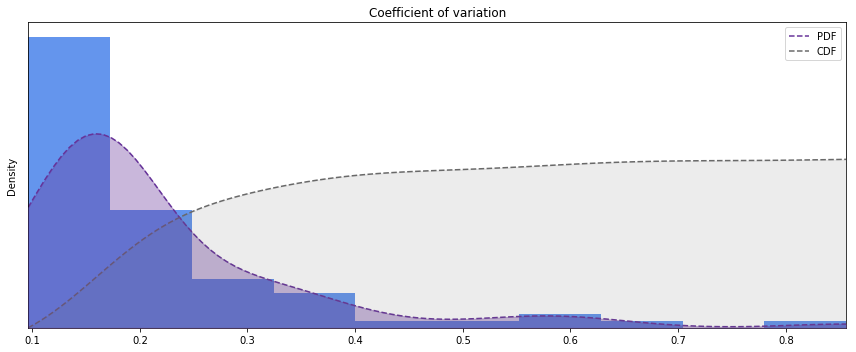

In [238]:
plot_histogram(description.loc["cova"], title="Coefficient of variation")

Based on this distribution, 0.3 appears to be a good cut-off value.

In [193]:
high_cova = description.loc["cova"].where(lambda x: x > 0.30).dropna().sort_values(ascending=False)
high_cova

AcetylH3K9_N    0.856000
pERK_N          0.631665
DYRK1A_N        0.584803
BRAF_N          0.570875
SOD1_N          0.516329
ITSN1_N         0.407210
pP70S6_N        0.395343
pCAMKII_N       0.365657
pPKCG_N         0.338945
Tau_N           0.327855
pELK_N          0.326353
S6_N            0.320205
H3AcK18_N       0.319686
pPKCAB_N        0.315412
ADARB1_N        0.302102
Name: cova, dtype: float64

Normality tests can also be used to identify interesting genes.  Either the Anderson-Darling test or the Shapiro-Wilks test works well in this role.

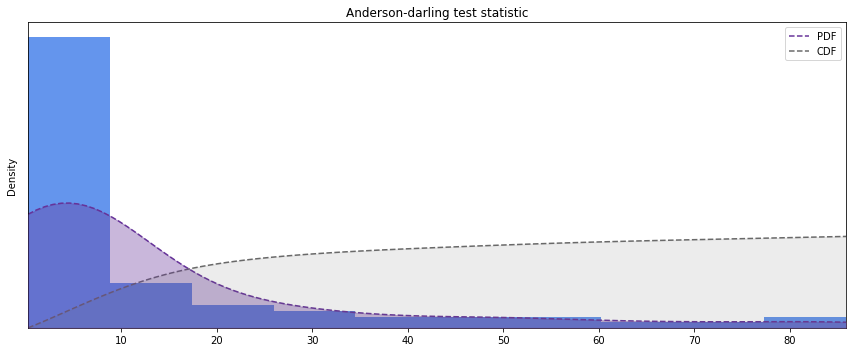

In [249]:
norm = pd.Series([anderson(df_numeric[c])[0] for c in df_numeric], index=df_numeric.columns)

plot_histogram(norm, title="Anderson-darling test statistic")

Based on this distribution, 20 seems like a good cut-off value.

In [223]:
description.loc['anderson'] = norm

high_anderson = description.loc['anderson'].where(lambda x: x > 20).dropna().sort_values(ascending=False)
high_anderson

BRAF_N          85.892736
AcetylH3K9_N    85.783742
DYRK1A_N        74.352495
pERK_N          66.770354
pELK_N          58.045646
Tau_N           52.473828
ITSN1_N         48.509978
SOD1_N          46.589849
RRP1_N          40.618962
BCL2_N          35.070336
H3AcK18_N       29.416407
H3MeK4_N        29.278540
ELK_N           26.198888
pPKCAB_N        25.716155
EGR1_N          24.663063
BAD_N           20.816607
Name: anderson, dtype: float64

We can use these results to filter our data set.  If we create sets from the result indices, we can take their intersections and unions to create complex filters.

In [224]:
high_anderson_and_cova = set(high_anderson.index) & set(high_cova.index)
print(high_anderson_and_cova)

{'DYRK1A_N', 'pELK_N', 'BRAF_N', 'H3AcK18_N', 'SOD1_N', 'Tau_N', 'ITSN1_N', 'pPKCAB_N', 'pERK_N', 'AcetylH3K9_N'}


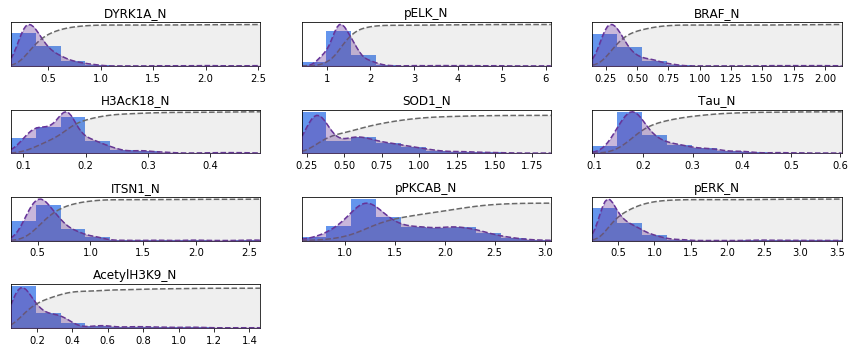

In [225]:
gene_data = [df[gene] for gene in high_anderson_and_cova]

plot_histogram(*gene_data, title=high_anderson_and_cova)

In [251]:
output_notebook()

skews = df_numeric.apply(lambda x: skew(x))
skews.name = "skew"
kurts = df_numeric.apply(lambda x: kurtosis(x))
kurts.name = "kurtosis"
genes = pd.Series([i.split("_")[0] for i in kurts.index], index=kurts.index, name="gene")
sk_df = pd.concat([skews, kurts, genes], axis=1)
fig = scatter_with_hover(sk_df, "skew", "kurtosis")
show(fig, notebook_handle=True);

Loading BokehJS ...

In [13]:
high_skew_kurt = sk_df.loc[((skews * kurts).abs() >= 2),["skew", "kurtosis"]]
high_skew_kurt

,skew,kurtosis
DYRK1A_N,4.356940,27.302549
ITSN1_N,3.622487,21.481122
pAKT_N,0.584313,3.581784
pELK_N,3.994880,25.609647
pERK_N,3.835335,22.367986
BRAF_N,4.547660,28.176251
ELK_N,1.364099,2.542970
GSK3B_N,0.999845,4.275637
JNK_N,-0.881214,3.972161
SOD1_N,1.300914,1.683064


In [123]:
import hdbscan

fit = hdbscan.HDBSCAN(min_cluster_size=12).fit(ecdf_normalized_df)
base_sample_clusters = pd.Series(fit.labels_, index=ecdf_normalized_df.index)

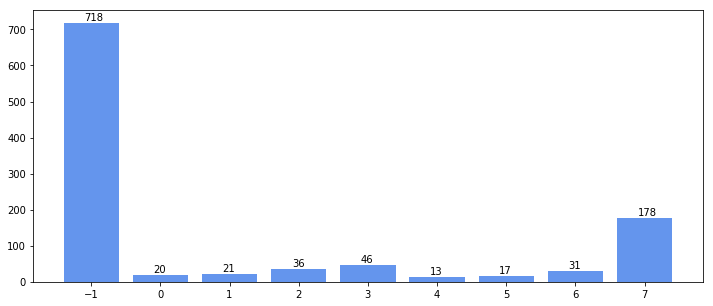

In [239]:
from collections import Counter

def counter_histogram(labels):
    counts = Counter(labels)
    fig, ax = plt.subplots()
    int_keys = [int(k) for k in counts.keys()]
    ax.bar(int_keys, list(counts.values()), color=bar_color)
    ax.set_xticks(sorted(int_keys))
    
    k_range = max(counts.keys()) - min(counts.keys())
    max_v = max(counts.values())
    
    def offset(k, v):
        return (k - k_range * 0.0125, v + max_v * 0.01)
    
    for (k, v) in counts.items():
        ax.annotate(str(v), offset(k, v))
    
counter_histogram(base_sample_clusters)

Note that the initial clustering results are fairly poor.  This is because each sample has a very large number of dimensions that vary independently.  As a result, points tend towards a common average distance, with poorly defined clusters.  We need to reduce the number of genes used in cluster analysis to improve results.

We already have some gene selection criteria in the form of coefficient of variance and divergence from normality.  In addition to this, we're going to cluster the genes, and include any that are part of a distinct cluster.

In [240]:
import networkx as nx

def reorder_rows(fit, df):
    clusters = fit.single_linkage_tree_.to_networkx()
    leaf_nodes = set([n for n in clusters.nodes()
                      if clusters.in_degree(n) != 0  and clusters.out_degree(n) == 0])
    index_order = {i: v for i, v in enumerate(df.index)}
    rows = [index_order[int(c)] for c in nx.topological_sort(clusters) if c in leaf_nodes]
    return df.loc[rows]

clustered_df = ecdf_normalized_df.assign(cluster=base_sample_clusters)
sorted_df = reorder_rows(fit, clustered_df).sort_values("cluster")
transpose_df = sorted_df.drop("cluster", 1).transpose()

t_fit = hdbscan.HDBSCAN(min_cluster_size=5).fit(transpose_df)

dimension_clusters = pd.Series(t_fit.labels_, index=transpose_df.index)

t_clustered_df = transpose_df.assign(cluster=dimension_clusters)
t_sorted_df = reorder_rows(t_fit, t_clustered_df).sort_values("cluster")

clustered_only = t_sorted_df[t_sorted_df["cluster"] >= 0]

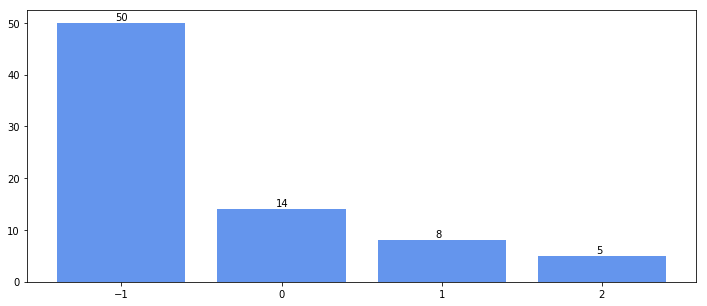

In [241]:
counter_histogram(dimension_clusters)

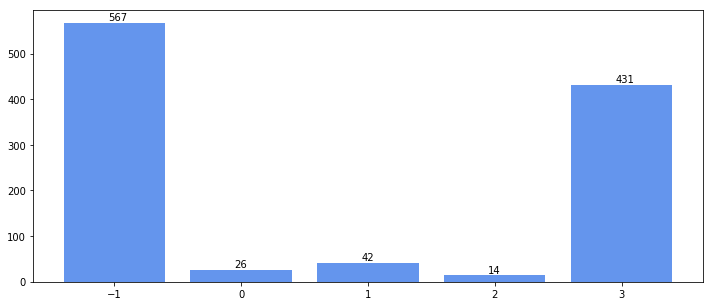

In [242]:
interesting_genes = list(set(high_anderson.index) | set(high_cova.index) | set(high_skew_kurt.index) |
                         set(clustered_only.index))
interesting_df = ecdf_normalized_df[interesting_genes]
fit = hdbscan.HDBSCAN(min_cluster_size=12).fit(interesting_df)
interesting_sample_clusters = pd.Series(fit.labels_, index=interesting_df.index)

counter_histogram(interesting_sample_clusters)

Unfortunately, manually selecting variables didn't seem to help that much.  The next step is to try dimensionality reduction.

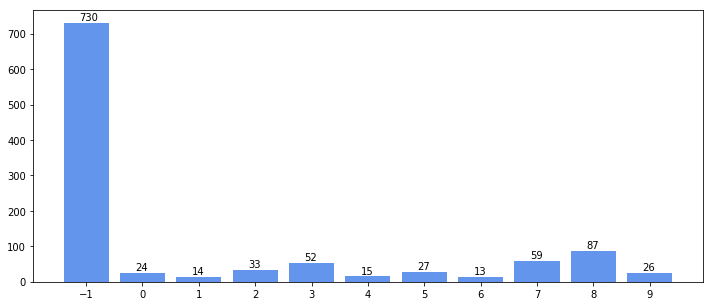

In [243]:
ic = FastICA(n_components=12)
reduced_df = pd.DataFrame(ic.fit_transform(ecdf_normalized_df), index=ecdf_normalized_df)

fit = hdbscan.HDBSCAN(min_cluster_size=12).fit(reduced_df)
reduced_sample_clusters = pd.Series(fit.labels_, index=interesting_df.index)

counter_histogram(reduced_sample_clusters)

Unfortunately, even performing dimensionality reduction didn't improve the results.  It looks like the baseline clustering is the best of the bunch.

In [244]:
df_clustered = clustered_df["cluster"] >= 0
sorted_clustered = sorted_df["cluster"] >= 0
cols = ["Genotype", "Treatment", "Behavior"]
in_cluster = df[df_clustered]
cluster_conditions = sorted_df[sorted_clustered].loc[:, ["cluster"]]
cluster_conditions = cluster_conditions.join(in_cluster[cols])

group_cluster = cluster_conditions.groupby("cluster")

behavior_counts = [pd.Series(group["Behavior"].value_counts(), name="Cluster %s" % idx) 
                   for (idx, group) in group_cluster]
behavior_counts = pd.DataFrame(behavior_counts).fillna(0)

def count_mice(group):
    return len(set(i.split("_")[0] for i in group.index))

mouse_counts = [count_mice(group) for (idx, group) in group_cluster]
mice = pd.Series(mouse_counts, name="mice", index=behavior_counts.index)
behavior_counts.join(mice)

,C/S,S/C,mice
Cluster 0,20.0,0.0,4
Cluster 1,21.0,0.0,2
Cluster 2,0.0,36.0,4
Cluster 3,0.0,46.0,6
Cluster 4,13.0,0.0,3
Cluster 5,17.0,0.0,3
Cluster 6,31.0,0.0,9
Cluster 7,1.0,177.0,23


That separation of condition by cluster appears pretty good.  The next step is to dig deeper into the cluster category structure.

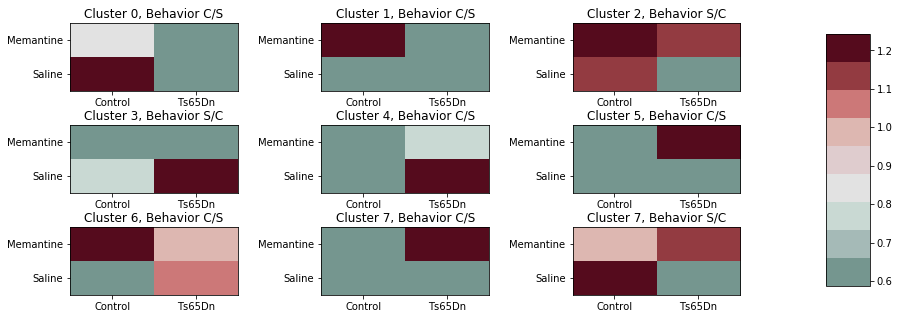

In [245]:
group_cluster_behavior = cluster_conditions.groupby(["cluster","Behavior"])

fig, axes = plt.subplots(3, 3)

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
my_cmap = ListedColormap(colors, name='my_name')

for g, a in zip_longest(group_cluster_behavior, axes.flatten()):
    if g is None:
        a.axis("off")
        break
    ((idx, cond), group) = g
    x = [1 if l == "Ts65Dn" else 0 for l in group["Genotype"]]
    y = [1 if l == "Memantine" else 0 for l in group["Treatment"]]
    res = a.hist2d(x, y, bins=2, range=[[0, 1], [0, 1]], normed=True, cmap=my_cmap)[3]
    a.set_title("Cluster %s, Behavior %s" % (idx, cond))
    a.set_xticklabels(["Control", "Ts65Dn"])
    a.set_xticks([0.25, 0.75])
    a.set_yticklabels(["Saline", "Memantine"])
    a.set_yticks([0.25, 0.75])
    a.set_xlim(0, 1)
    a.set_ylim(0, 1)

fig.subplots_adjust(wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax);

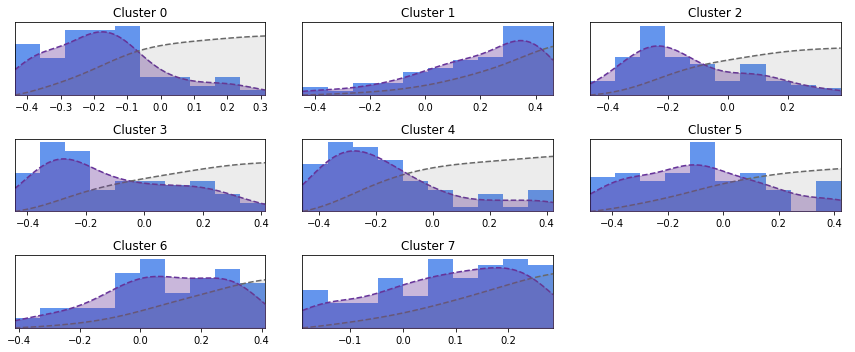

In [235]:
def diff_genes(df):
    return df.apply(lambda x: x.mean() - 0.5).sort_values()

clusters = list(range(base_sample_clusters.max() + 1))
diffs = [diff_genes(sorted_df.filter(like="_N", axis=1)[sorted_df["cluster"] == i]) for i in clusters]

titles = ["Cluster %s" % c for c in clusters]
plot_histogram(*diffs, title=titles)

# Identifying significant variables

In order to determine how significant a variable is to overall cluster assignment, we can look at the differences between the cluster mean percentiles and overall mean percentiles.  The larger the difference, the more significant.  If we do this for all variables and put the results in a vector, the norm of that vector represents a measure of a variable's clustering importance.  We can use that measure to rank and filter variables.

In [23]:
diffs_df = pd.DataFrame(diffs).transpose()
norms = pd.Series(np.sqrt(np.square(diffs_df).sum(axis=1)), name="norm")

diffs_df.join(norms).sort_values('norm', ascending=False)[:20]

,0,1,2,3,4,5,6,7,norm
pERK_N,0.013750,0.346605,-0.197634,-0.425866,0.422792,0.373965,0.330108,-0.154671,0.890080
SYP_N,-0.188009,0.438801,-0.299846,-0.291184,-0.395798,-0.230937,0.274701,0.159514,0.844679
pELK_N,-0.281157,0.351190,-0.063735,-0.443418,0.365527,0.349074,0.232885,-0.018997,0.844467
BRAF_N,-0.146296,0.264021,-0.195010,-0.387782,0.394516,0.406536,0.302210,-0.128922,0.841653
H3AcK18_N,-0.328056,-0.199824,-0.223148,0.309138,-0.408547,-0.404085,-0.281691,-0.034072,0.838819
CaNA_N,0.237361,0.317284,-0.400797,-0.111977,0.205698,0.424020,0.341338,-0.175650,0.836454
DYRK1A_N,-0.096806,0.276587,-0.117130,-0.337158,0.417165,0.407571,0.329271,-0.139414,0.825387
GSK3B_N,0.063380,0.385362,-0.241384,-0.315781,0.119302,0.411329,0.411918,-0.008828,0.814667
ITSN1_N,-0.146528,0.297928,-0.130376,-0.289795,0.385399,0.405392,0.363978,-0.074506,0.813705
H3MeK4_N,-0.385880,0.182407,-0.170190,0.287762,-0.321083,-0.386383,-0.320341,0.077715,0.809315


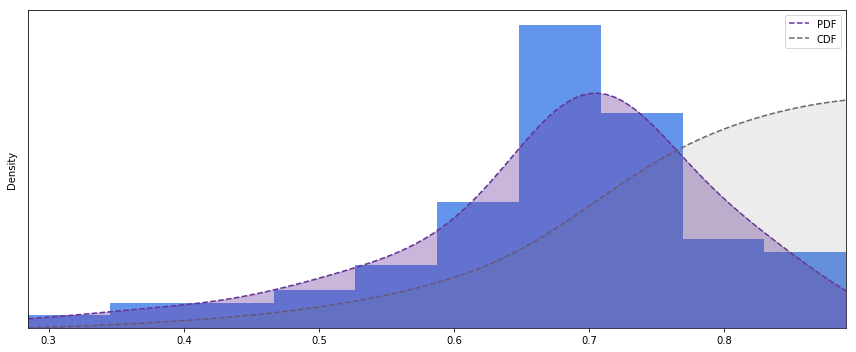

In [246]:
plot_histogram(norms)

There aren't extreme outliers on the distribution of the norms.

In [253]:
categorical_columns = ["Genotype", "Treatment", "Behavior"]
small_df = t_sorted_df.drop("cluster", 1).loc[:,df_clustered]
conditions = df.loc[:, categorical_columns]

In [247]:
def only_samples_where(df, genotype=None, treatment=None, behavior=None):
    genotype = genotype or set()
    treatment = treatment or set()
    behavior = behavior or set()
    df = df.transpose().join(conditions)
    
    def mask(value=False):
        return pd.Series([value for _ in df.index], dtype=bool, index=df.index)
    
    m = mask(True)
    
    if genotype:
        genotype_mask = mask(False)
        if "Control" in genotype:
            genotype_mask |= df["Genotype"] == "Control"
        if "Ts65Dn" in genotype:
            genotype_mask |= df["Genotype"] == "Ts65Dn"
        m &= genotype_mask
    
    if treatment:
        treatment_mask = mask(False)
        if "Memantine" in treatment:
            treatment_mask |= df["Treatment"] == "Memantine"
        if "Saline" in treatment:
            treatment_mask |= df["Treatment"] == "Saline"
        m &= treatment_mask
        
    if behavior:
        behavior_mask = mask(False)
        if "C/S" in behavior:
            behavior_mask |= df["Behavior"] == "C/S"
        if "S/C" in behavior:
            behavior_mask |= df["Behavior"] == "S/C"
        m &= behavior_mask
        
        return df[m].drop(categorical_columns, axis=1).transpose()

In [250]:
def filtered_heatmap(genotype, treatment, behavior):
    filtered_df = only_samples_where(small_df, genotype=genotype, treatment=treatment, behavior=behavior)
    fig = block_heatmap(filtered_df, width=875)
    show(fig, notebook_handle=True)

genotype_opts = {"All": "Control Ts65Dn", "Control": "Control", "Ts65Dn": "Ts65Dn"}
treatment_opts = {"All": "Memantine Saline", "Saline": "Saline", "Memantine": "Memantine"}
behavior_opts = {"All": "C/S S/C", "Learning": "C/S", "No learning": "S/C"}
interact(filtered_heatmap, genotype=genotype_opts, treatment=treatment_opts, behavior=behavior_opts);

This beast of a plot shows patterns of activity for every gene in the database.